# League of Legends Side and Picks Analysis

**Name(s)**: Nathaphat Taleongpong, Gahn Wuwong

**Website Link**: [website](https://gahnxd.github.io/League-of-Legends-Project/)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import plotly.express as px
pd.options.plotting.backend = 'plotly'
from dsc80_utils import *

In [141]:
# fig.write_html('file-name.html', include_plotlyjs='cdn')

## Step 1: Introduction

In [142]:
file_path = '_LoL_esports_match_data_from_OraclesElixir.csv'
df = pd.read_csv('data/' + '2022' + file_path)
for year in range(2023,2025):
    path = 'data/' + str(year) + file_path
    file = pd.read_csv(path)
    df = pd.concat([df, file])
df = df.reset_index(drop=True)
df.head()

c:\Users\Putt\miniforge3\envs\dsc80\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



,gameid,datacompleteness,url,league,...,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT01_2690210,complete,NaN,LCKC,...,0.0,0.0,1.0,0.0
1,ESPORTSTMNT01_2690210,complete,NaN,LCKC,...,2.0,0.0,5.0,1.0
2,ESPORTSTMNT01_2690210,complete,NaN,LCKC,...,0.0,3.0,3.0,2.0
3,ESPORTSTMNT01_2690210,complete,NaN,LCKC,...,2.0,3.0,3.0,0.0
4,ESPORTSTMNT01_2690210,complete,NaN,LCKC,...,2.0,0.0,6.0,2.0


In [143]:
df.shape

(326592, 131)

### Introduction and Question Identification	

Understand the data you have access to. Brainstorm a few questions that interest you about the dataset. Pick one question you plan to investigate further. (As the data science lifecycle tells us, this question may change as you work on your project.)

**Hypothesis Testing**:    
- Are you more likely to win if you have Yasuo on your team?      
- Both red and blue team have the same chance of winning

**Machine Learning:**     
- After the banning phase in champ selection, what bans would be the most likely to win?     
- Given two team bans, which is more likely to get the first baron?

**Question to Investigate Further:** Depending on the team bans, do both blue and red teams have the same chance of winning?

## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning

In [144]:
pd.options.display.max_rows = 100
df = df[df['datacompleteness'] == 'complete']
columns = 'gameid, game, side, result, league, teamname, teamid, date, champion, ban1, ban2, ban3, ban4, ban5, \
goldat15, xpat15, csat15, golddiffat15, xpdiffat15, csdiffat15, killsat15, assistsat15, deathsat15'
df = df[columns.split(', ')]
df['date']  = pd.to_datetime(df['date'])
df = df.reset_index(drop=True)
df.head()

,gameid,game,side,result,...,csdiffat15,killsat15,assistsat15,deathsat15
0,ESPORTSTMNT01_2690210,1,Blue,0,...,14.0,0.0,1.0,0.0
1,ESPORTSTMNT01_2690210,1,Blue,0,...,-11.0,2.0,3.0,2.0
2,ESPORTSTMNT01_2690210,1,Blue,0,...,1.0,0.0,3.0,0.0
3,ESPORTSTMNT01_2690210,1,Blue,0,...,-34.0,2.0,1.0,2.0
4,ESPORTSTMNT01_2690210,1,Blue,0,...,7.0,1.0,2.0,2.0


In [145]:
# Check for missing values
df.isna().sum()

gameid              0
game                0
side                0
result              0
league              0
teamname           54
teamid           3324
date                0
champion        45386
ban1              786
ban2              426
ban3             1080
ban4              810
ban5             1458
goldat15           24
xpat15             24
csat15             24
golddiffat15       24
xpdiffat15         24
csdiffat15         24
killsat15          24
assistsat15        24
deathsat15         24
dtype: int64

In [146]:
# Drop games without gameid
games = df.copy()
games.dropna(subset=['gameid'], inplace=True)
games = games.reset_index(drop=True)
games.isna().sum()

gameid              0
game                0
side                0
result              0
league              0
teamname           54
teamid           3324
date                0
champion        45386
ban1              786
ban2              426
ban3             1080
ban4              810
ban5             1458
goldat15           24
xpat15             24
csat15             24
golddiffat15       24
xpdiffat15         24
csdiffat15         24
killsat15          24
assistsat15        24
deathsat15         24
dtype: int64

In [147]:
games_to_drop = games.loc[games['golddiffat15'].isna(), 'gameid'].unique()
games = games.drop(games[games['gameid'].isin(games_to_drop)].index)
games = games.reset_index(drop=True)
games.head()

,gameid,game,side,result,...,csdiffat15,killsat15,assistsat15,deathsat15
0,ESPORTSTMNT01_2690210,1,Blue,0,...,14.0,0.0,1.0,0.0
1,ESPORTSTMNT01_2690210,1,Blue,0,...,-11.0,2.0,3.0,2.0
2,ESPORTSTMNT01_2690210,1,Blue,0,...,1.0,0.0,3.0,0.0
3,ESPORTSTMNT01_2690210,1,Blue,0,...,-34.0,2.0,1.0,2.0
4,ESPORTSTMNT01_2690210,1,Blue,0,...,7.0,1.0,2.0,2.0


In [148]:
# Drop games with missing ban picks
games_to_drop = games.loc[games.iloc[:, 12:17].isna().sum(axis=1).astype(bool), 'gameid'].unique()
games = games.drop(games[games['gameid'].isin(games_to_drop)].index)
games = games.reset_index(drop=True)
games

,gameid,game,side,result,...,csdiffat15,killsat15,assistsat15,deathsat15
0,ESPORTSTMNT01_2690210,1,Blue,0,...,14.0,0.0,1.0,0.0
1,ESPORTSTMNT01_2690210,1,Blue,0,...,-11.0,2.0,3.0,2.0
2,ESPORTSTMNT01_2690210,1,Blue,0,...,1.0,0.0,3.0,0.0
3,ESPORTSTMNT01_2690210,1,Blue,0,...,-34.0,2.0,1.0,2.0
4,ESPORTSTMNT01_2690210,1,Blue,0,...,7.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...
268735,LOLTMNT02_93919,2,Red,0,...,14.0,1.0,0.0,1.0
268736,LOLTMNT02_93919,2,Red,0,...,-116.0,0.0,0.0,0.0
268737,LOLTMNT02_93919,2,Red,0,...,94.0,0.0,0.0,1.0
268738,LOLTMNT02_93919,2,Blue,1,...,-11.0,3.0,5.0,3.0


In [149]:
games.isna().sum()

gameid              0
game                0
side                0
result              0
league              0
teamname           54
teamid           3138
date                0
champion        44790
ban1              606
ban2              270
ban3              864
ban4                0
ban5                0
goldat15            0
xpat15              0
csat15              0
golddiffat15        0
xpdiffat15          0
csdiffat15          0
killsat15           0
assistsat15         0
deathsat15          0
dtype: int64

We decided to drop games that don't have a gameid because we won't be able to group by games with no id. Since we can't impute missing bans, we have to drop all games that have missing bans.

In [150]:
games.head()

,gameid,game,side,result,...,csdiffat15,killsat15,assistsat15,deathsat15
0,ESPORTSTMNT01_2690210,1,Blue,0,...,14.0,0.0,1.0,0.0
1,ESPORTSTMNT01_2690210,1,Blue,0,...,-11.0,2.0,3.0,2.0
2,ESPORTSTMNT01_2690210,1,Blue,0,...,1.0,0.0,3.0,0.0
3,ESPORTSTMNT01_2690210,1,Blue,0,...,-34.0,2.0,1.0,2.0
4,ESPORTSTMNT01_2690210,1,Blue,0,...,7.0,1.0,2.0,2.0


### Univariate Analysis

In [151]:
# Univariate analysis plot - Distribution of Games per Match
fig = px.histogram(games, x='game', title='Distribution of Games per Match')
fig.update_layout(xaxis_title='Games', yaxis_title='Count')
fig.update_traces(marker_color='steelblue')
fig.show()
# fig.write_html('Univariate_GPerM.html', include_plotlyjs='cdn')

In [152]:
# Univariate analysis plot - Distribution of Sides
fig = px.histogram(games, x='side', title='Distribution of Sides')
fig.update_layout(xaxis_title='Sides', yaxis_title='Count')
fig.update_traces(marker_color=['steelblue', 'tomato'])
fig.show()


### Bivariate Analysis

In [153]:
# Bivariate analysis plot - Distribution of Win Rate by Side
win_rate = games.groupby(['gameid', 'teamname'])['result', 'side'].max().groupby('side')['result'].mean().reset_index()
fig = px.pie(win_rate, values='result', names='side', title='Win Rate by Side')
fig.update_traces(marker=dict(colors=['steelblue', 'tomato']))
fig.update_layout(legend_title_text='Side')
fig.show()
# fig.write_html('Bivariate_SideWinRate.html', include_plotlyjs='cdn')

C:\Users\Putt\AppData\Local\Temp\ipykernel_912\1968205466.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [154]:
# Bivariate analysis plot - Distribution of Win Rate by Banned Characters
bans = games.melt(id_vars=['result'], value_vars=['ban1', 'ban2', 'ban3', 'ban4', 'ban5'], var_name='ban', value_name='character')

# Calculate win rate
win_rate = bans.groupby('character')['result'].mean().reset_index()
win_rate = win_rate.sort_values(by='result', ascending=False).iloc[0:20]
# Plot the win rates using Plotly
fig = px.bar(win_rate, x='character', y='result', title='Win Rate by Banned Character', labels={'result': 'Win Rate', 'character': 'Banned Character'})
fig.update_traces(marker_color='steelblue')
fig.show()

# fig.write_html('Bivariate_BannedWinRate.html', include_plotlyjs='cdn')

### Interesting Aggregates

In [155]:
# Pivot table - Win Rate for each banned character and side
bans = games.melt(id_vars=['result', 'side'], value_vars=['ban1', 'ban2', 'ban3', 'ban4', 'ban5'], var_name='ban', value_name='character')
win_rate = bans.groupby(['character', 'side'])['result'].mean().reset_index()
win_rate.columns = ['ban', 'side', 'win rate']

pivot_table = pd.pivot_table(win_rate, index='side', columns='ban', values='win rate', aggfunc='sum', fill_value=0)
# print(pivot_table.head().to_markdown())
pivot_table

ban,Aatrox,Ahri,Akali,Akshan,...,Ziggs,Zilean,Zoe,Zyra
side,,,,,,,,,
Blue,0.51,0.54,0.54,0.58,...,0.60,0.55,0.53,0.47
Red,0.47,0.49,0.47,0.52,...,0.55,0.51,0.47,0.42


## Step 3: Assessment of Missingness

### NMAR

We believe that the columns `ban1` to `ban5` is NMAR because players can choose to ban or not to ban. However, the game format may have changed over time, so we will explore whether the missingness in the ban columns are MAR depending on the year and month.

### MAR

**Question**: Is `ban4` and `ban5` MAR depending on year and month?

In [156]:
bans = df.melt(id_vars='date', value_vars=['ban1', 'ban2', 'ban3', 'ban4', 'ban5'], var_name='ban', value_name='character')
bans = bans[bans['ban'].isin(['ban4', 'ban5'])]
bans['year'] = bans['date'].dt.year
bans['year-month'] = bans['date'].dt.to_period('M')
bans['missing'] = bans['character'].isna()
bans.head()

,date,ban,character,year,year-month,missing
816948,2022-01-10 07:44:08,ban4,Thresh,2022,2022-01,False
816949,2022-01-10 07:44:08,ban4,Thresh,2022,2022-01,False
816950,2022-01-10 07:44:08,ban4,Thresh,2022,2022-01,False
816951,2022-01-10 07:44:08,ban4,Thresh,2022,2022-01,False
816952,2022-01-10 07:44:08,ban4,Thresh,2022,2022-01,False


**MAR Depending on Year**

**Null Hypothesis**: Missingness of `ban4` and `ban5` is not dependent on `year`.     
   
**Alternate Hypothesis**: Missingness of `ban4` and `ban5` is dependent on `year`.       

**Test Statistic**: TVD between distribution of `year` by missing and not missing `ban4` and `ban5`.

**Significance Level**: 0.05

In [157]:
tvds = []
iter = 1000
bans_copy = bans.copy()[['year', 'year-month', 'missing']]

for _ in tqdm(range(iter)):
    bans_copy['missing'] = np.random.permutation(bans_copy['missing'])
    pivot = pd.pivot_table(bans_copy, index='year', columns='missing', values='missing', aggfunc='size', fill_value=0)
    distribution = pivot/pivot.sum()
    distribution = distribution.diff(axis=1).abs().sum().iloc[1] / 2
    tvds.append(distribution)

100%|██████████| 1000/1000 [00:34<00:00, 28.71it/s]


In [158]:
fig = px.histogram(x=tvds, title='Distribution of TVDs')
fig.update_layout(xaxis_title='TVD', yaxis_title='Count')
fig.update_traces(marker_color='steelblue')
fig.show()

In [159]:
obs = pd.pivot_table(bans[['year', 'year-month', 'missing']], index='year', columns='missing', values='missing', aggfunc='size', fill_value=0)
obs = obs/obs.sum()
obs = obs.diff(axis=1).abs().sum().iloc[1] / 2
obs

0.0769543513973454

In [160]:
fig = px.histogram(x=tvds, title='Distribution of TVDs')
fig.update_layout(xaxis_title='TVD', yaxis_title='Count')
fig.add_shape(type='line', x0=obs, x1=obs, y0=0, y1=90, line=dict(color='red', width=3))
fig.update_layout(showlegend=False)
fig.update_traces(marker_color='steelblue')
fig.show()

In [161]:
(tvds >= obs).mean()

0.0

The p-value is 0, which is lower than the significance level, so we reject the null hypothesis. This means that `ban4` and `ban5` is dependent on `year`.

**MAR Depending on Year and Month**

**Null Hypothesis**: Missingness of `ban4` and `ban5` is not dependent on `year-month`.     
   
**Alternate Hypothesis**: Missingness of `ban4` and `ban5` is dependent on `year-month`.       

**Test Statistic**: TVD between distribution of `year` by missing and not missing `ban4` and `ban5`.

**Significance Level**: 0.05

In [162]:
tvds = []
iter = 1000
bans_copy = bans.copy()[['year', 'year-month', 'missing']]

for _ in tqdm(range(iter)):
    bans_copy['missing'] = np.random.permutation(bans_copy['missing'])
    pivot = pd.pivot_table(bans_copy, index='year-month', columns='missing', values='missing', aggfunc='size', fill_value=0)
    distribution = pivot/pivot.sum()
    distribution = distribution.diff(axis=1).abs().sum().iloc[1] / 2
    tvds.append(distribution)

100%|██████████| 1000/1000 [00:36<00:00, 27.42it/s]


In [163]:
fig = px.histogram(x=tvds, title='Distribution of TVDs')
fig.update_layout(xaxis_title='TVD', yaxis_title='Count')
fig.update_traces(marker_color='steelblue')
fig.show()

In [164]:
obs = pd.pivot_table(bans[['year', 'year-month', 'missing']], index='year-month', columns='missing', values='missing', aggfunc='size', fill_value=0)
obs = obs/obs.sum()
obs = obs.diff(axis=1).abs().sum().iloc[1] / 2
obs

0.16627490727541616

In [165]:
fig = px.histogram(x=tvds, title='Distribution of TVDs')
fig.update_layout(xaxis_title='TVD', yaxis_title='Count')
fig.add_shape(type='line', x0=obs, x1=obs, y0=0, y1=90, line=dict(color='red', width=3))
fig.update_layout(showlegend=False)
fig.update_traces(marker_color='steelblue')
fig.show()

In [166]:
(tvds >= obs).mean()

0.0

The p-value is 0, which is lower than the significance level, so we reject the null hypothesis. This means that the missingness in `ban4` and `ban5` is dependent on `year-month`.

This dependency on year and month is due to the seasonal changes in the format of the game. Moving forward, we will be using the game's latest ban format, so we will remove any games that previously only had 2 bans and 3 bans. Additionally, to make the data easier to use and analyze, we will only include games where both teams banned 5 characters.

In [167]:
games.isna().sum()

gameid              0
game                0
side                0
result              0
league              0
teamname           54
teamid           3138
date                0
champion        44790
ban1              606
ban2              270
ban3              864
ban4                0
ban5                0
goldat15            0
xpat15              0
csat15              0
golddiffat15        0
xpdiffat15          0
csdiffat15          0
killsat15           0
assistsat15         0
deathsat15          0
dtype: int64

## Step 4: Hypothesis Testing

**Question**: Do both blue and red teams have the same chance of winning?       

**Null Hypothesis**: Blue and red teams have the same chances of winning.       

**Alternative Hypothesis**: Blue and red teams don't have the same changes of winning.       

**Test Statistic**: The absolute difference in win rate between blue and red teams.      

**Significance Level**: 0.05        

In [168]:
win_rate = games.groupby(['gameid', 'teamid'])[['result', 'side']].max().reset_index()
win_rate.head()

,gameid,teamid,result,side
0,ESPORTSTMNT01_2690210,oe:team:68911b3329146587617ab2973106e23,0,Blue
1,ESPORTSTMNT01_2690210,oe:team:d2dc3681437e2beb2bb4742477108ff,1,Red
2,ESPORTSTMNT01_2690219,oe:team:5380cdbc2ad2b8082624f48f99f6672,1,Red
3,ESPORTSTMNT01_2690219,oe:team:6dcacec00a6ba7576c5ab7f30c995cd,0,Blue
4,ESPORTSTMNT01_2690227,oe:team:b9733b8e8aa341319bbaf1035198a28,1,Blue


In [169]:
wr_copy = win_rate.copy()
iter = 10000
n = len(wr_copy['side'])

diffs = []

samples = np.random.multinomial(n, [1/2]*2, iter)/n
diffs = np.abs(samples[:, 0] - samples[:, 1])

In [170]:
fig = px.histogram(x=diffs, title='Distribution of Win Rate Differences')
fig.update_layout(xaxis_title='Win Rate Difference', yaxis_title='Count')
fig.update_traces(marker_color='steelblue')
fig.show()

In [171]:
obs = win_rate.groupby('side')['result'].mean().sort_index(ascending=False).diff().abs().iloc[-1]
obs

0.05667898795858628

In [172]:
fig = px.histogram(x=diffs, title='Distribution of Win Rate Differences')
fig.update_layout(xaxis_title='Win Rate Difference', yaxis_title='Count')
fig.add_shape(type='line', x0=obs, x1=obs, y0=0, y1=420, line=dict(color='red', width=3))
fig.update_layout(showlegend=False)
fig.update_traces(marker_color='steelblue')
fig.show()

In [173]:
(diffs >= obs).mean()

0.0

The p-value is 0, which is lower than the significance level, so we reject the null hypothesis. This means that blue and red teams don't have the same chances of winning. 

We suspect that this might be because of the format of the bans pick, since the blue team gets to pick some of their bans before the red team.

## Step 5: Framing a Prediction Problem

Since the blue and red teams have different chances of winning, we aim to explore whether this bias can be leveraged to predict the game's outcome. To enhance the prediction's accuracy, we will also use the bans as features. Bans are crucial to the game and are the only information we have before the game starts, given the absence of data on picks. 

**Prediction Problem**      
Our prediction problem is a classification task. Specifically, we are performing binary classification to predict the outcome of a game (win or loss) based on the side and bans.

**Response Variable**       
The response variable is the game's result, which can be either a win (1) or a loss (0).

**Model**       
We will be using a CatBoost Classifier to predict the game's outcome based on the side and bans. The reason we chose the CatBoost Classifier is because it can handle categories that appear in the test set but were not present in the training set. This capability is particularly important is our dataset where the banned characters might vary between training and testing sets.

**Evaluation Metric**       
We will use accuracy to evaluate our model. Accuracy is chosen because the proportions of wins and losses are nearly balanced (47% for red and 53% for blue), making it an appropriate metric to assess the model's overall performance in correctly predicting game outcomes. Accuracy provides a clear and direct measure of the model's effectiveness.

## Step 6: Baseline Model

In [174]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time

In [175]:
ohe = pd.get_dummies(games.dropna(subset=['champion'])['champion']).reset_index(drop=True)
ohe['gameid'] = games['gameid']
ohe['side'] = games['side']
ohe = ohe.groupby(['gameid', 'side']).sum().reset_index()
ohe.head()

,gameid,side,Aatrox,Ahri,...,Ziggs,Zilean,Zoe,Zyra
0,ESPORTSTMNT01_2690210,Blue,0,0,...,0,0,0,0
1,ESPORTSTMNT01_2690210,Red,0,0,...,0,0,0,0
2,ESPORTSTMNT01_2690219,Blue,0,0,...,0,0,1,0
3,ESPORTSTMNT01_2690219,Red,0,0,...,0,0,0,0
4,ESPORTSTMNT01_2690227,Blue,0,0,...,0,0,0,0


In [176]:
games.head()

,gameid,game,side,result,...,csdiffat15,killsat15,assistsat15,deathsat15
0,ESPORTSTMNT01_2690210,1,Blue,0,...,14.0,0.0,1.0,0.0
1,ESPORTSTMNT01_2690210,1,Blue,0,...,-11.0,2.0,3.0,2.0
2,ESPORTSTMNT01_2690210,1,Blue,0,...,1.0,0.0,3.0,0.0
3,ESPORTSTMNT01_2690210,1,Blue,0,...,-34.0,2.0,1.0,2.0
4,ESPORTSTMNT01_2690210,1,Blue,0,...,7.0,1.0,2.0,2.0


In [177]:
game_data = games.groupby(['gameid', 'side'])[['game', 'result','golddiffat15', 'xpdiffat15', 'csdiffat15', 
                                      'killsat15', 'assistsat15', 'deathsat15']].last().reset_index()
game_data = game_data.merge(ohe, on=['gameid', 'side'])
game_data.head()

,gameid,side,game,result,...,Ziggs,Zilean,Zoe,Zyra
0,ESPORTSTMNT01_2690210,Blue,1,0,...,0,0,0,0
1,ESPORTSTMNT01_2690210,Red,1,1,...,0,0,0,0
2,ESPORTSTMNT01_2690219,Blue,1,0,...,0,0,1,0
3,ESPORTSTMNT01_2690219,Red,1,1,...,0,0,0,0
4,ESPORTSTMNT01_2690227,Blue,1,1,...,0,0,0,0


In [178]:
X = game_data.drop(columns=['gameid', 'result'])
y = game_data['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_base = X_train.drop(columns=['game', 'golddiffat15', 'xpdiffat15', 'csdiffat15','killsat15', 'assistsat15', 'deathsat15'])
X_test_base = X_test.drop(columns=['game', 'golddiffat15', 'xpdiffat15', 'csdiffat15','killsat15', 'assistsat15', 'deathsat15'])

In [179]:
start = time.time()

categorical_features = ['side']
target_feature = ['result']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

randomForest_base = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        max_depth=25,
        n_estimators=100,
        min_samples_leaf=5,
    ))
])

randomForest_base.fit(X_train_base, y_train)

end = time.time()
print(end-start, 'seconds')

3.2968342304229736 seconds


In [180]:
train_score = randomForest_base.score(X_train_base, y_train)
test_score = randomForest_base.score(X_test_base, y_test)
print(f"Train score: {train_score}, Test score: {test_score}")

Train score: 0.6417950435365036, Test score: 0.5145995178140905


## Step 7: Final Model

### Feature Engineering

We decided to experiment with more numerical features within the data. We added the difference in gold, xp, and cs at 15 minutes into the game in order to better determine if the team has an advantage early on in the game. We will also use the number of kills, assists, and death in the first 15 minutes to better predict the probability of the team winning. Additionally, we also included the game number of the match to takeinto account of the stamina of the players.

### Grid Search Cross Validation

**Hyperparameters**     

`n_estimators`: Number of decision trees. More iterations can capture more patterns but increase training time.    

`max_depth`: Depth of the trees. Controls the complexity of the model. Deeper trees can model more complex interactions but may overfit.  

`min_samples_leaf`: Minimum number of samples required to be at a leaf node. Helps prevent overfitting.  

`max_features`: The function used to decide how many features to consider when fitting. Helps prevent overfitting.  

In [181]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [182]:
start = time.time()

numerical_features = ['golddiffat15', 'xpdiffat15', 'csdiffat15', 'killsat15', 'assistsat15', 'deathsat15']
categorical_features = ['side']
target_feature = ['result']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

randomForest_final = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        max_depth=25,
        n_estimators=100,
        min_samples_leaf=5,
    ))
])

randomForest_final.fit(X_train, y_train)

end = time.time()
print(end-start, 'seconds')

3.5612058639526367 seconds


In [183]:
train_score = randomForest_final.score(X_train, y_train)
test_score = randomForest_final.score(X_test, y_test)
print(f"Train score: {train_score}, Test score: {test_score}")

Train score: 0.8038847957133288, Test score: 0.7468523975354943


In [184]:
start = time.time()

numerical_features = ['golddiffat15', 'xpdiffat15', 'csdiffat15', 'killsat15', 'assistsat15', 'deathsat15']
categorical_features = ['side']
target_feature = ['result']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

randomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

hyperparameters = {
    'classifier__max_depth': [20, 25, 30],
    'classifier__min_samples_leaf': [6, 9, 12],
    'classifier__n_estimators': [75, 100, 125],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(randomForest, hyperparameters, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

end = time.time()
print(end-start, 'seconds')

162.19090509414673 seconds


In [185]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test score: {test_score}")

Best parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 9, 'classifier__n_estimators': 125}
Best cross-validation score: 0.7492632283991962
Test score: 0.7472542191267078


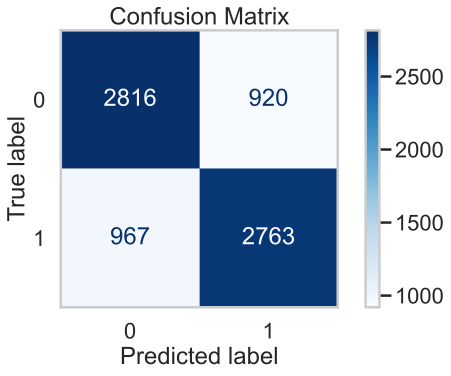

In [201]:
from matplotlib import pyplot as plt


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, best_model.predict(X_test)), display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')
plt.grid(False)
plt.show()


In [204]:
# import numpy as np
# import plotly.graph_objects as go
# from sklearn.metrics import confusion_matrix

# # Assuming y_test and best_model are already defined
# cm = confusion_matrix(y_test, best_model.predict(X_test))
# labels = best_model.classes_

# # Create a heatmap for the confusion matrix without text
# fig = go.Figure(data=go.Heatmap(
#     z=cm,
#     x=labels,
#     y=labels,
#     colorscale='Blues',
#     showscale=True,
#     hoverinfo="skip"  # Disable hover info to keep it clean
# ))

# # Add layout details
# fig.update_layout(
#     title='Confusion Matrix',
#     xaxis=dict(title='Predicted label', tickmode='array', tickvals=np.arange(len(labels)), ticktext=labels),
#     yaxis=dict(title='True label', tickmode='array', tickvals=np.arange(len(labels)), ticktext=labels),
#     autosize=False,
#     width=500,
#     height=500,
#     margin=dict(l=50, r=50, b=50, t=50, pad=4),
#     font=dict(size=16)
# )

# # Add annotations
# annotations = []
# for i in range(len(labels)):
#     for j in range(len(labels)):
#         annotations.append(
#             dict(
#                 x=j,
#                 y=i,
#                 text=str(cm[i, j]),
#                 showarrow=False,
#                 font=dict(size=16, color="white" if cm[i, j] > np.max(cm) / 2 else "black"),
#                 xanchor='center',
#                 yanchor='middle'
#             )
#         )

# fig.update_layout(annotations=annotations)

# # Save the figure as an HTML file
# fig.write_html('Confusion.html', include_plotlyjs='cdn')

# # Optionally, display the Plotly figure
# fig.show()


## Step 8: Fairness Analysis

**Question**: Does my model have a similar performance for both blue and red sides?       

**Null Hypothesis**: Our model is fair. The accuracy of the model is roughly the same for both sides and any differences are due to random chance.       

**Alternative Hypothesis**: Our model is unfair. The accuracy of the model is significantly different for both sides.       

**Test Statistic**: The absolute difference in accuracy between blue and red teams.      

**Significance Level**: 0.05        

In [187]:
from sklearn.metrics import accuracy_score

In [188]:
predictions = best_model.predict(X_test)
results = X_test.copy()[['side']]
results['actual'] = y_test
results['predicted'] = predictions
results.head()

,side,actual,predicted
34091,Red,1,1
12135,Red,1,0
27158,Blue,1,1
34577,Red,1,1
9525,Red,1,0


In [189]:
results.groupby('side').apply(lambda x: accuracy_score(x['actual'], x['predicted']))

side
Blue    0.75
Red     0.74
dtype: float64

In [190]:
results_copy = results.copy()
diffs = []
iter = 10000
for _ in tqdm(range(iter)):
    results_copy['side'] = np.random.permutation(results_copy['side'])
    stat = results_copy.groupby('side').apply(lambda x: accuracy_score(x['actual'], x['predicted'])).diff().abs().iloc[-1]
    diffs.append(stat)

100%|██████████| 10000/10000 [00:22<00:00, 445.97it/s]


In [191]:
fig = px.histogram(x=diffs, title='Distribution of Absolute Difference in Accuracy')
fig.update_layout(xaxis_title='Absolute Difference in Accuracy', yaxis_title='Count')
fig.update_traces(marker_color='steelblue')
fig.show()

In [192]:
obs = results.groupby('side').apply(lambda x: accuracy_score(x['actual'], x['predicted'])).diff().abs().iloc[-1]
obs

0.01069479765940573

In [193]:
fig = px.histogram(x=diffs, title='Distribution of Absolute Difference in Accuracy')
fig.update_layout(xaxis_title='Absolute Difference in Accuracy', yaxis_title='Count')
fig.add_shape(type='line', x0=obs, x1=obs, y0=0, y1=500, line=dict(color='red', width=3))
fig.update_layout(showlegend=False)
fig.update_traces(marker_color='steelblue')
fig.show()

In [194]:
(diffs >= obs).mean()

0.303

The p-value is higher than the significance level, so we fail to reject the null hypothesis. This means that our model is fair and the difference in accuracy between blue and red teams is due to random chance.